In [1]:
import qiskit as qk
from qiskit import QuantumCircuit
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
import math
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
from qiskit import Aer
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder

from NEQR import build_neqr

from utils import *

В image_10 помещается изображение размером $4\times 4$.

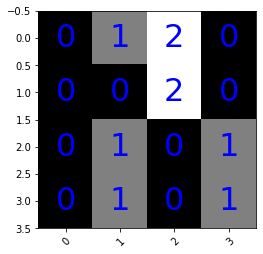

In [2]:
image_10 = [0,1,2,0,0,0,2,0,0,1,0,1,0,1,0,1]
image = np.array(["000"]*16, dtype=str)

for i,x in enumerate(image_10):
    num = format(x, f"0{len(image[0])}b")
    image[i] = num

fig, ax = plt.subplots()
plot_array(np.array(image_10).reshape(4,4), fig, ax)

shifting_plus $-$ функция для реализаци сдвига на +1 по координате, соответствующей указанному регистру. В качестве параметров принимает цепь и регистр к которой применяется функция.

In [3]:
def shifting_plus(circ, q_reg): 
    n = q_reg.size
    for i in range(1, n)[::-1]:
        circ.mct(q_reg[0:i], q_reg[i], mode='noancilla')      
    circ.x(q_reg[0])

build_neqr_test $-$ функция для кодирования изображения в квантовом представлении изображения NEQR. В качестве параметров принимает изображение, которое нужно закодировать, цепь в которую нужно поместить изображение, а также регистры в этой цепи, которые будут отвечать за хранение местоположения по оси $x$ и $y$, а также значение пикселя.

In [4]:
def build_neqr_test(image: np.ndarray, NEQR_circuit, position_value_x, position_value_y, color_value):

    image_size = len(image)

    position_num_y = position_value_y.size
    position_num_x = position_value_x.size
    position_num = position_num_y + position_num_x


    intensity_num = len(image[0])
    intensity_num = color_value.size
   
    
    for n in range(image_size):
        value = format(n, f"0{position_num}b")
        for position, position_value_value in enumerate(value[::-1]):
            if(position_value_value =="0"):
                NEQR_circuit.x(position + intensity_num*2 + 4) 
        for position_1, px_value_1 in enumerate(image[n][::-1]):
            if(px_value_1 == "1"):
                NEQR_circuit.mct([*position_value_x, *position_value_y], color_value[position_1], mode='noancilla')  
        for position, position_value_value in enumerate(value[::-1]):
            if(position_value_value =="0"):
                NEQR_circuit.x(position + intensity_num*2 + 4)                     
        NEQR_circuit.barrier()  


Здесь происходит создание необходимых для хранения регистров, цепей, а также вспомогательных для умножениия и деления кубит. 

In [5]:
image_size = len(image)

intensity_num = len(image[0])
NEQR_circuit = QuantumCircuit()

auxiliary = QuantumRegister(4, "auxiliary")
NEQR_circuit.add_register(auxiliary)

for i in range(2):
    img = QuantumRegister(intensity_num, f"image_{i}")
    NEQR_circuit.add_register(img)


position_num_y = int(math.log(image_size, 2)/2)
position_num_x = int(math.log(image_size, 2)/2)
position_value_x = QuantumRegister(position_num_x, "position_value_x")
position_value_y = QuantumRegister(position_num_y, "position_value_y")


NEQR_circuit.add_register(position_value_x)
NEQR_circuit.add_register(position_value_y)

NEQR_circuit.h(NEQR_circuit.qregs[3][:]+NEQR_circuit.qregs[4][:]) #Переделать в автоматическое определение регистра, сейчас в ручную это делается. Устанавливается суперпозиция, перед тем как начинать навешивать схему


#### Изображение со сдвигом (x+1), (y+1).

Работа с первой картинкой: помещение представления изображения с помощью build_neqr_test, и реализация сдвига по оси x и y.
 

In [6]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[1])
shifting_plus(NEQR_circuit, NEQR_circuit.qregs[4])# (y+1) 
shifting_plus(NEQR_circuit, NEQR_circuit.qregs[3])# (x+1) 

### Оригинальное изображение

In [7]:
build_neqr_test(image, NEQR_circuit, position_value_x, position_value_y, NEQR_circuit.qregs[2])

Реализация умножения первого изображения на 2, а второго на 4.

In [8]:
for i in range(auxiliary.size + intensity_num - 1):
    NEQR_circuit.swap(NEQR_circuit.qubits[i], NEQR_circuit.qubits[i + 1])


for i in range(auxiliary.size + (intensity_num - 2)):
    NEQR_circuit.swap(NEQR_circuit.qubits[i], NEQR_circuit.qubits[i + 1])
    
for i in range(auxiliary.size + (intensity_num - 3)):
    NEQR_circuit.swap(NEQR_circuit.qubits[i], NEQR_circuit.qubits[i + 1])

Cумма изображений с помощью DraperQFTAdder

In [9]:
adder = DraperQFTAdder(intensity_num+2, kind = "fixed")

NEQR_circuit = NEQR_circuit.compose(adder, qubits=NEQR_circuit.qubits[0:5] + NEQR_circuit.qubits[5:10])

Деление суммы изображений на 2.

In [10]:
for i in range(auxiliary.size + intensity_num - 2, auxiliary.size + ((intensity_num)*2 - 1)):
    NEQR_circuit.swap(NEQR_circuit.qubits[i], NEQR_circuit.qubits[i + 1])

Симуляция и измерение полученной схемы.

In [11]:
from qiskit.providers.aer import AerSimulator

NEQR_circuit.measure_all()

extended_stabilizer_simulator = AerSimulator(method='statevector', extended_stabilizer_sampling_method = 'norm_estimation')
extended_stabilizer_simulator.set_options(precision='single')

tsmall_circ = transpile(NEQR_circuit, extended_stabilizer_simulator)
print("Transpiled")


result = extended_stabilizer_simulator.run(tsmall_circ, shots = 20000).result()
counts = result.get_counts(0)
print('100 shots in {}s'.format(result.time_taken))

Transpiled
100 shots in 0.16497302055358887s


Выбор наиболее вероятных состояний. Перевод значений местоположений пикселей из двоичной системы в десятичную.

In [12]:
from collections import defaultdict
import textwrap

position_size = 4
splitter = lambda x: (int(x[0][:position_size],2), x[1],  x[0][position_size:position_size+10])
elements = list(map(splitter, zip(counts.keys(), counts.values())))

d = defaultdict(list)    
for x in elements:
    d[x[0]].append((x[1], list(map(lambda x: int(x,2),textwrap.wrap(x[2],5)))))

res = []
for x in d:
    res.append((x, max(d[x])[1:]))

def get_shift_array(shift_ind):
    pixels = []
    for i,one_pos in enumerate(sorted(res)):
        pixels.append(one_pos[1][0][shift_ind])
    pixels = np.array(pixels).reshape(4,4)
    return pixels

Визуализация результатов измерения схемы. Конечный ответ находится в первом изображении, второе изображение содержит изображение со сдвигом, умноженное на два, третье $-$ это оригинал, который изображен для наглядности.

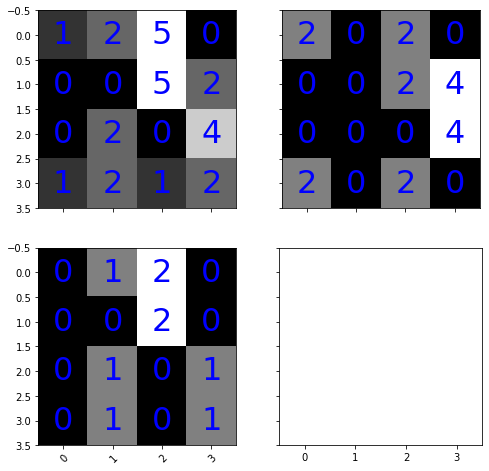

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex='all', sharey='all', figsize=(8,8))
plot_array(get_shift_array(0), fig, axes[0,0])
plot_array(get_shift_array(1), fig, axes[0,1])
plot_array(np.array(image_10).reshape(4,4), fig, axes[1,0])